In [ ]:
!pip install pycountry

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pycountry

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:

df = pd.read_csv('/content/hotel_bookings.csv')
null_counts = df.isnull().sum()
null_columns = null_counts[null_counts > 0]
#print(null_columns,"\n")
#print(f"{len(null_columns)} columns have null values.")

# Add a 'reservation_count' column to facilitate counting
df['reservation_count'] = 1

# Observe the country field
hotel_pivot = df[['country','hotel','reservation_count']]\
.pivot_table(index=['country'],columns=['hotel'], aggfunc='sum').sort_values(by=[('reservation_count','City Hotel')], ascending=False)
percentage_table = hotel_pivot.div(hotel_pivot.sum(axis=0), axis=1) * 100


#Impute 'PRT' with country missing values
df['country'].fillna('PRT', inplace=True)

df['is_local'] = df['country'].apply(lambda x: 1 if x == 'PRT' else 0)

#Calculate the proportion of the 'children' column
df['children'].value_counts(normalize=True)*100

#Fill null values in 'children' column with 0 (the most common value)
df['children'].fillna(0, inplace=True)
#and convert the column to integer type
df['children'] = df['children'].astype(int)

#Create a total_guests column
df['total_guests'] = df['adults'] + df['children'] + df['babies']

#evaluate the ratio between the values ​​of the number of guests with value count and average daily rate (adr)
agg_df = df[['total_guests','adr','reservation_count']].groupby(by='total_guests').agg({'adr': 'mean', 'reservation_count': 'sum'})
agg_df['proportion (%)'] = df['total_guests'].value_counts(normalize=True).sort_index()*100


df['total_guests'].between(1,5).value_counts(normalize=True)*100

#filter data to include a total geusts between 1 and 5 guests
df = df[df['total_guests'].between(1,5)]
#
df['total_guests'].unique()

#Create a guest_composition column
df['guest_composition'] = df['adults'].astype(str)+"/"+ (df['children']+df['babies']).astype(str)

df[['guest_composition','adults','children','babies']].sample(5)

(df['agent'].value_counts(normalize=True,dropna=False)*100).head().sort_index()

#is_agent proportion
df['is_agent'] = df['agent'].apply(lambda x: 0 if pd.isnull(x) else 1)
(df['is_agent'].value_counts(normalize=True,dropna=False)*100).head()

(df['company'].value_counts(normalize=True,dropna=False)*100).head().sort_index()

#is_company column
df['is_company'] = df['company'].apply(lambda x: 0 if pd.isnull(x) else 1)

#แปลง df ของ column "total_of_special_requests", 'required_car_parking_spaces' ให้มีค่าแค่ 0 หรือ 1 โดยค่าที่เป็น 0 ให้่เท่ากับ 0 ค่าที่มากกว่าเท่ากับ 1 ให้แปลงเป็น 1
df['total_of_special_requests'] = df['total_of_special_requests'].apply(lambda x: 0 if x == 0 else 1)
df['required_car_parking_spaces'] = df['required_car_parking_spaces'].apply(lambda x: 0 if x == 0 else 1)
df = df.rename(columns={'total_of_special_requests': 'is_special_requests', 'required_car_parking_spaces': 'is_car_parking'})
# prompt: เพิ่ม column ที่แปลง Hotel เป็น 0 และ 1 โดยให้ Resort เป็น 1 City เป็น 0 ชื่อ column ว่า hotel_type
df['hotel_type'] = df['hotel'].apply(lambda x: 1 if x == 'Resort Hotel' else 0)


<ipython-input-30-2ee5bb802880>:17: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



<ipython-input-30-2ee5bb802880>:25: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

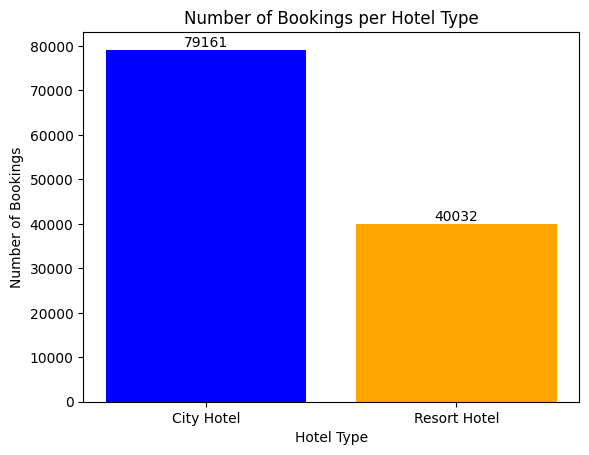

In [ ]:
# Assuming 'hotel' column contains hotel types
hotel_type_counts = df.groupby('hotel').size().reset_index(name='count')

# Create the bar chart
plt.bar(hotel_type_counts['hotel'], hotel_type_counts['count'], color=['blue', 'orange'])

# Add labels and title
plt.xlabel('Hotel Type')
plt.ylabel('Number of Bookings')
plt.title('Number of Bookings per Hotel Type')

# Add data labels to each bar
for i, count in enumerate(hotel_type_counts['count']):
  plt.text(i, count, str(count), ha='center', va='bottom')

# Display the chart
plt.show()

In [ ]:
df['arrival_date_month']

,arrival_date_month
0,July
1,July
2,July
3,July
4,July
...,...
119385,August
119386,August
119387,August
119388,August


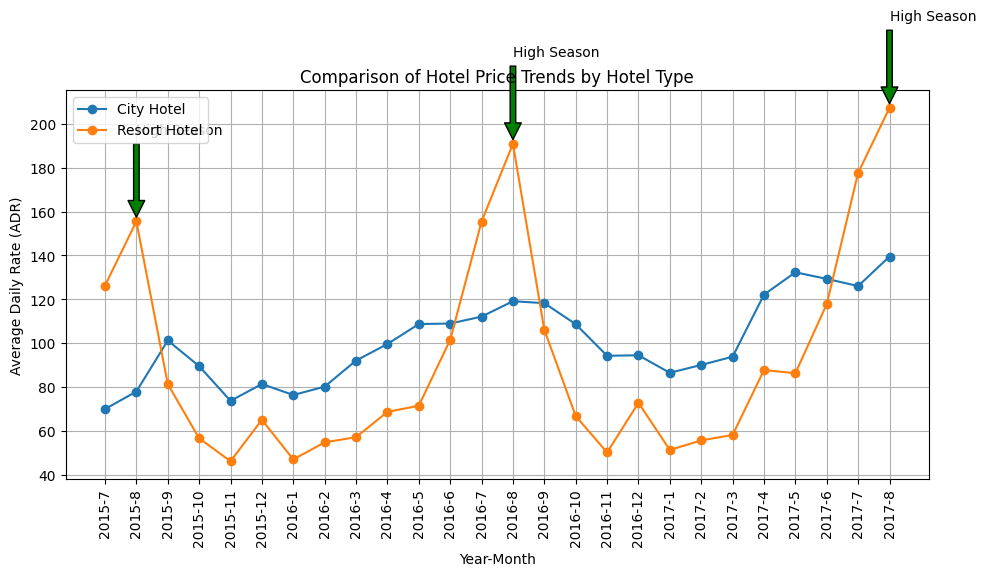

In [ ]:
# Convert arrival_date_month to a datetime format to order it correctly
df['arrival_date_month'] = pd.to_datetime(df['arrival_date_month'], format='%B').dt.month

# Group the data by arrival year and month, then calculate the average daily rate (ADR) for each group
price_trend = df.groupby(['arrival_date_year', 'arrival_date_month'])['adr'].mean().reset_index()

# Sort the data by year and month for better visualization
price_trend = price_trend.sort_values(by=['arrival_date_year', 'arrival_date_month'])

# Group the data by hotel type and month-year, and calculate the average daily rate (ADR)
price_trend_by_hotel = df.groupby(['hotel', 'arrival_date_year', 'arrival_date_month'])['adr'].mean().reset_index()

# Sort the data for better visualization
price_trend_by_hotel = price_trend_by_hotel.sort_values(by=['arrival_date_year', 'arrival_date_month'])
resort_data = price_trend_by_hotel[price_trend_by_hotel['hotel'] == 'Resort Hotel']

plt.figure(figsize=(10,6))

# Plotting the price trend for each hotel type again
for hotel in price_trend_by_hotel['hotel'].unique():
    subset = price_trend_by_hotel[price_trend_by_hotel['hotel'] == hotel]
    plt.plot(subset['arrival_date_year'].astype(str) + '-' + subset['arrival_date_month'].astype(str),
             subset['adr'], marker='o', label=hotel)

# Define the specific high season points (August in 2015, 2016, and 2017)
high_season_points = resort_data[(resort_data['arrival_date_year'].isin([2015, 2016, 2017])) &
                                 (resort_data['arrival_date_month'] == 8)]

# Add arrows for the high season points with adjusted text position to avoid overlap
for idx, row in high_season_points.iterrows():
    plt.annotate('High Season', xy=(f"{row['arrival_date_year']}-{row['arrival_date_month']}", row['adr']),
                 xytext=(f"{row['arrival_date_year']}-{row['arrival_date_month']}", row['adr'] + 40),
                 arrowprops=dict(facecolor='green', shrink=0.05))

plt.xticks(rotation=90)
plt.xlabel('Year-Month')
plt.ylabel('Average Daily Rate (ADR)')
plt.title('Comparison of Hotel Price Trends by Hotel Type')
plt.legend(loc='upper left')  # Move legend slightly
plt.grid(True)
plt.tight_layout()
plt.show()

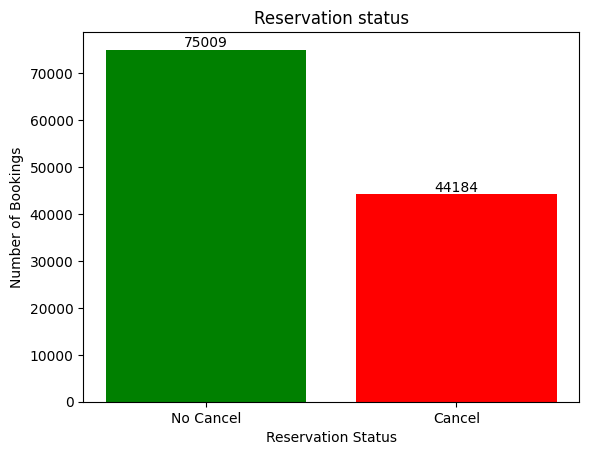

In [ ]:
# Count the number of reservations and cancellations
reservation_status_counts = df['is_canceled'].value_counts()

# Create a bar chart
plt.bar(reservation_status_counts.index, reservation_status_counts.values, color=['green', 'red'])

# Add labels and title
plt.xlabel('Reservation Status')
plt.ylabel('Number of Bookings')
plt.title('Reservation status')
plt.xticks([0, 1], ['No Cancel', 'Cancel'])  # Replace numeric labels with "No Cancel" and "Cancel"

# Add data labels to each bar
for i, count in enumerate(reservation_status_counts.values):
  plt.text(i, count, str(count), ha='center', va='bottom')

# Display the chart
plt.show()


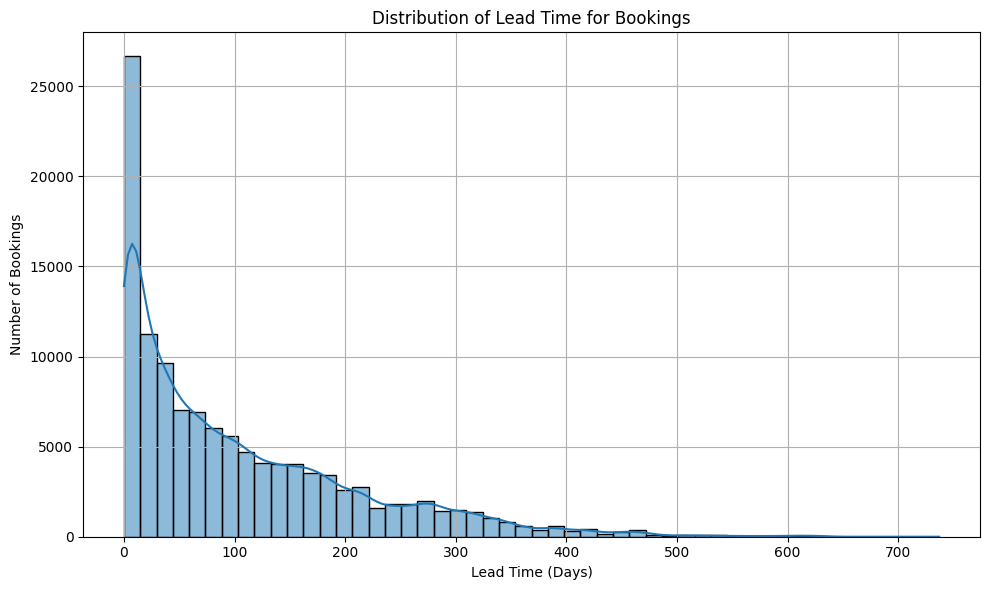

In [ ]:
# Let's create a visualization for the distribution of lead time for bookings.

plt.figure(figsize=(10,6))

# Plot the distribution of lead time
sns.histplot(data=df, x='lead_time', bins=50, kde=True)

plt.title('Distribution of Lead Time for Bookings')
plt.xlabel('Lead Time (Days)')
plt.ylabel('Number of Bookings')
plt.grid(True)
plt.tight_layout()
plt.show()



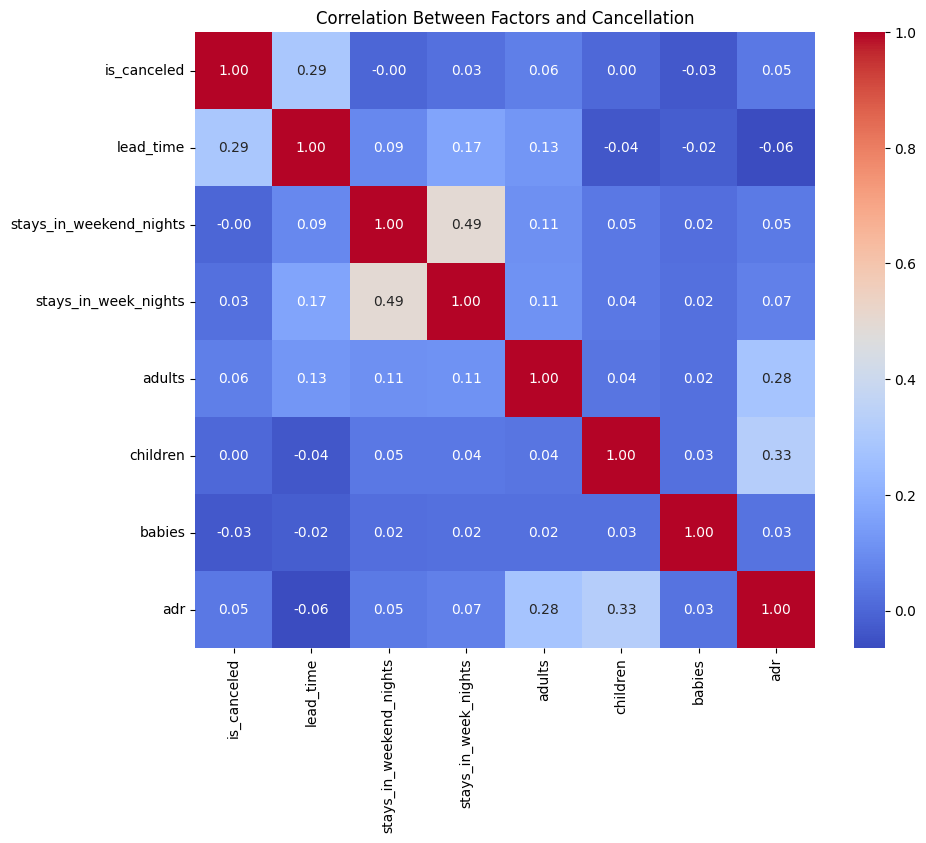

In [ ]:
columns_of_interest = [
    'is_canceled', 'lead_time', 'stays_in_weekend_nights', 'stays_in_week_nights',
    'adults', 'children', 'babies', 'adr'
]

df_selected = df[columns_of_interest]


# Correlation matrix to see relationships between variables and cancellations
correlation_matrix = df_selected.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f')
plt.title('Correlation Between Factors and Cancellation')
plt.show()

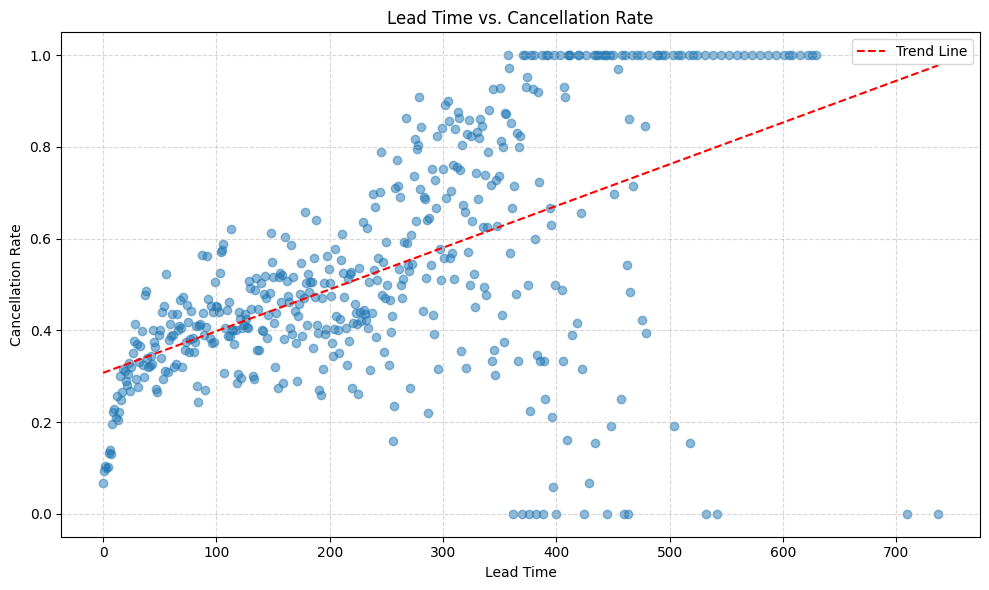

In [ ]:

# Calculate the cancellation rate for each lead time
cancellation_rates = df.groupby('lead_time')['is_canceled'].mean()

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(cancellation_rates.index, cancellation_rates.values, alpha=0.5)

# Calculate the trend line using linear regression
z = np.polyfit(cancellation_rates.index, cancellation_rates.values, 1)
p = np.poly1d(z)

# Plot the trend line
plt.plot(cancellation_rates.index, p(cancellation_rates.index), color='red', linestyle='--', label='Trend Line')

# Add labels and title
plt.xlabel('Lead Time')
plt.ylabel('Cancellation Rate')
plt.title('Lead Time vs. Cancellation Rate')
plt.legend()

# Customize the plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the plot
plt.show()


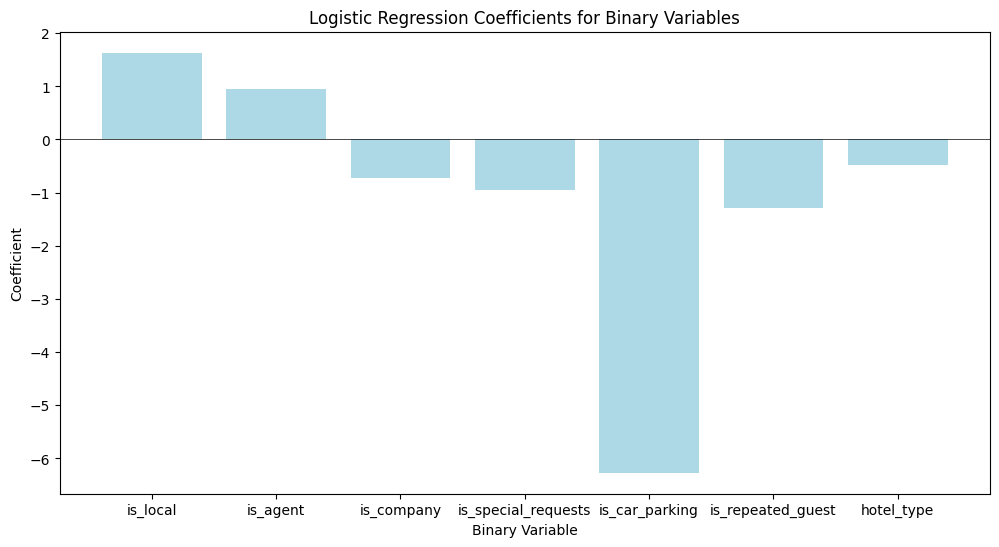

In [ ]:

binary_vars = ['is_local', 'is_agent', 'is_company', 'is_special_requests', 'is_car_parking', 'is_repeated_guest', 'hotel_type']
X = df[binary_vars]
y = df['is_canceled']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predicting the test set results
y_pred = log_reg.predict(X_test)

# Displaying the classification report to understand the model's performance
classification_report_output = classification_report(y_test, y_pred, output_dict=True)

# Extracting coefficients for the binary variables
coefficients = pd.DataFrame({
    'Variable': binary_vars,
    'Coefficient': log_reg.coef_[0]
})

# Fitting the logistic regression model
log_reg_binary = LogisticRegression()
log_reg_binary.fit(X, y)

# Extracting the coefficients
coefficients_binary = pd.DataFrame({
   'Variable': binary_vars,
   'Coefficient': log_reg_binary.coef_[0]
})

# Plotting the coefficients
plt.figure(figsize=(12, 6))
plt.bar(coefficients_binary['Variable'], coefficients_binary['Coefficient'], color='lightblue')
plt.title('Logistic Regression Coefficients for Binary Variables')
plt.xlabel('Binary Variable')
plt.ylabel('Coefficient')
plt.axhline(0, color='black',linewidth=0.5)
plt.show()

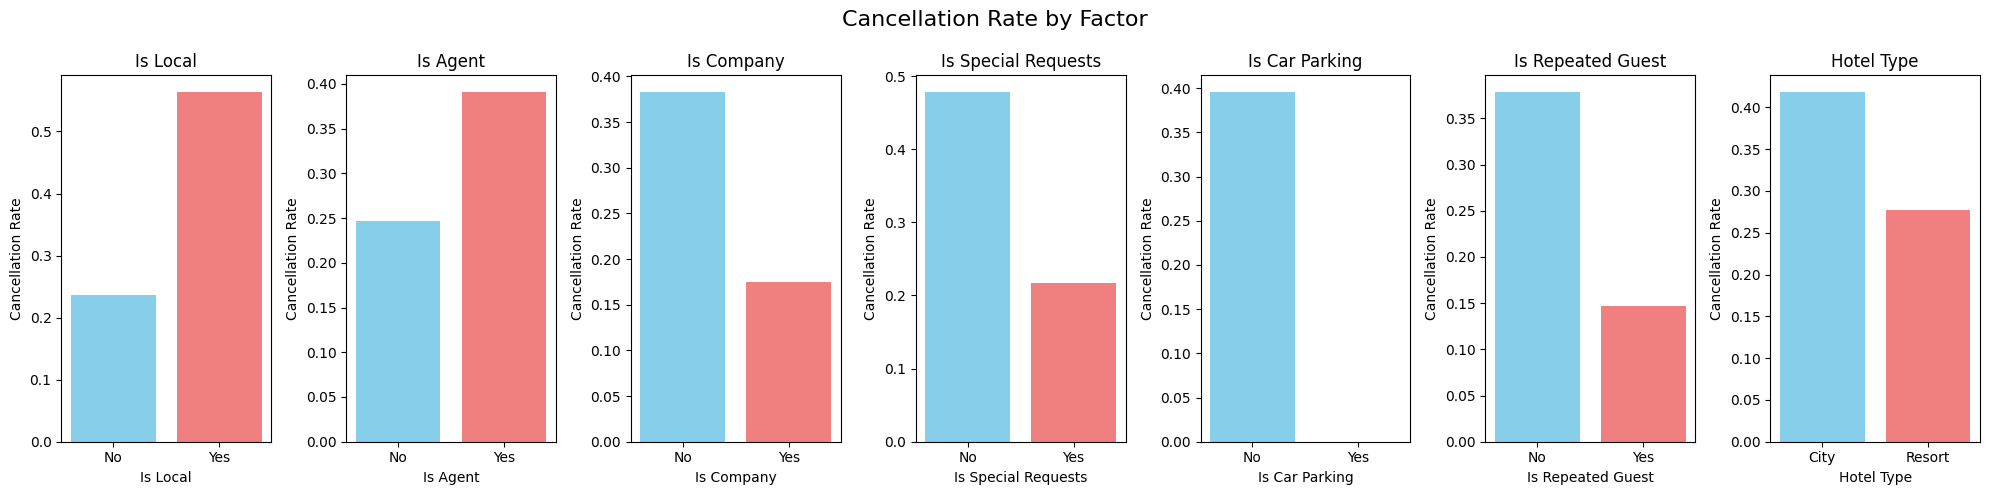

In [ ]:
# Create a dictionary to map values for the x-axis labels
label_mapping = {
    0: 'No',
    1: 'Yes'
}
hotel_type_mapping = {
    0: 'City',
    1: 'Resort'
}


# Create a figure and axes
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 5))
fig.suptitle('Cancellation Rate by Factor', fontsize=16)

# Iterate through the binary variables
for i, variable in enumerate(['is_local', 'is_agent', 'is_company', 'is_special_requests', 'is_car_parking', 'is_repeated_guest', 'hotel_type']):
    ax = axes[i]

    # Group by the variable and calculate the cancellation rate
    cancellation_rates = df.groupby(variable)['is_canceled'].mean()

    # Create the bar chart
    if variable == 'hotel_type':
        ax.bar(hotel_type_mapping.values(), cancellation_rates, color=['skyblue', 'lightcoral'])
        ax.set_xlabel(variable.replace('_', ' ').title())
        ax.set_ylabel('Cancellation Rate')
        ax.set_title(variable.replace('_', ' ').title())
    else:
        ax.bar(label_mapping.values(), cancellation_rates, color=['skyblue', 'lightcoral'])
        ax.set_xlabel(variable.replace('_', ' ').title())
        ax.set_ylabel('Cancellation Rate')
        ax.set_title(variable.replace('_', ' ').title())


# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


In [ ]:
binary_vars = ['is_local', 'is_agent', 'is_company', 'is_special_requests', 'is_car_parking', 'is_repeated_guest', 'hotel_type']

# Create an empty list to store the results
results = []

for variable in binary_vars:
  count_0 = (df[variable] == 0).sum()
  count_1 = (df[variable] == 1).sum()
  total_count = count_0 + count_1
  proportion_0 = (count_0 / total_count) * 100 if total_count > 0 else 0
  proportion_1 = (count_1 / total_count) * 100 if total_count > 0 else 0
  results.append([variable, count_0, count_1, proportion_0, proportion_1])

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Variable', 'Count_0', 'Count_1', 'Proportion_0 (%)', 'Proportion_1 (%)'])

# Display the DataFrame as a table with formatting
display(results_df)


,Variable,Count_0,Count_1,Proportion_0 (%),Proportion_1 (%)
0,is_local,70248,48945,58.936347,41.063653
1,is_agent,16271,102922,13.650969,86.349031
2,is_company,112425,6768,94.321814,5.678186
3,is_special_requests,70186,49007,58.884330,41.115670
4,is_car_parking,111784,7409,93.784031,6.215969
5,is_repeated_guest,115438,3755,96.849647,3.150353
6,hotel_type,79161,40032,66.414135,33.585865


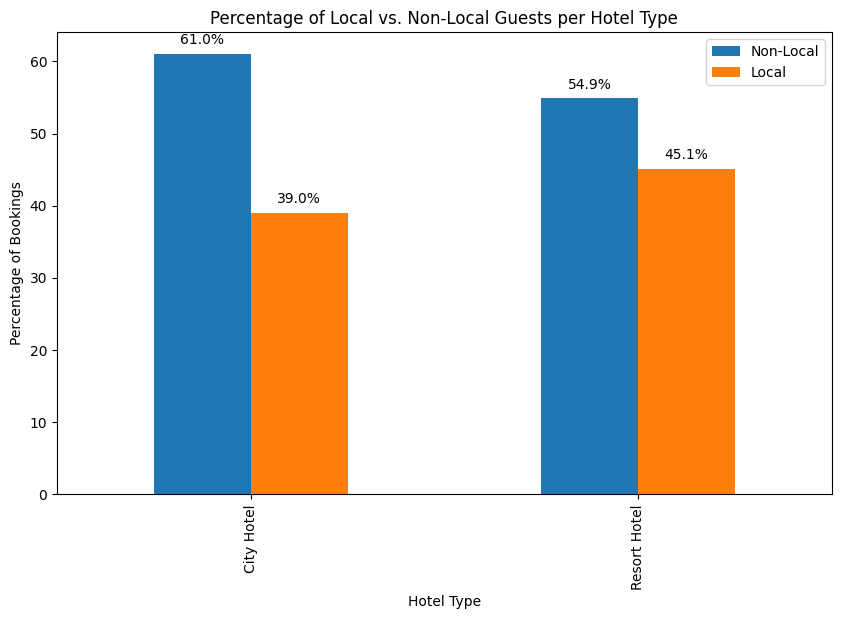

In [ ]:
# Group data by hotel type and local/non-local status, then calculate the percentage
hotel_guest_percentage = df.groupby(['hotel', 'is_local'])['reservation_count'].sum().unstack().fillna(0)
hotel_guest_percentage = hotel_guest_percentage.div(hotel_guest_percentage.sum(axis=1), axis=0) * 100

# Create the bar chart
ax = hotel_guest_percentage.plot(kind='bar', figsize=(10, 6))

# Add labels and title
plt.xlabel('Hotel Type')
plt.ylabel('Percentage of Bookings')
plt.title('Percentage of Local vs. Non-Local Guests per Hotel Type')
plt.legend(['Non-Local', 'Local'])

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Display the chart
plt.show()


In [ ]:
#cancellation_rates_by_country = df[df['country'] != 'PRT'].groupby('country').agg(
cancellation_rates_by_country = df.groupby('country').agg(
    total_bookings=('reservation_count', 'sum'),
    total_cancellations=('is_canceled', 'sum')
).reset_index()
cancellation_rates_by_country = cancellation_rates_by_country[cancellation_rates_by_country['total_bookings'] >= 100]
cancellation_rates_by_country['cancellation_rate'] = (cancellation_rates_by_country['total_cancellations'] / cancellation_rates_by_country['total_bookings']) * 100

# Plot heatmap อัตราการยกเลิกตามแผนที่โลก
fig = px.choropleth(cancellation_rates_by_country, locations="country", locationmode='ISO-3',
                    color="cancellation_rate", hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title_text='Cancellation Rate by Country, (minimum 100 bookings)')
fig.show()


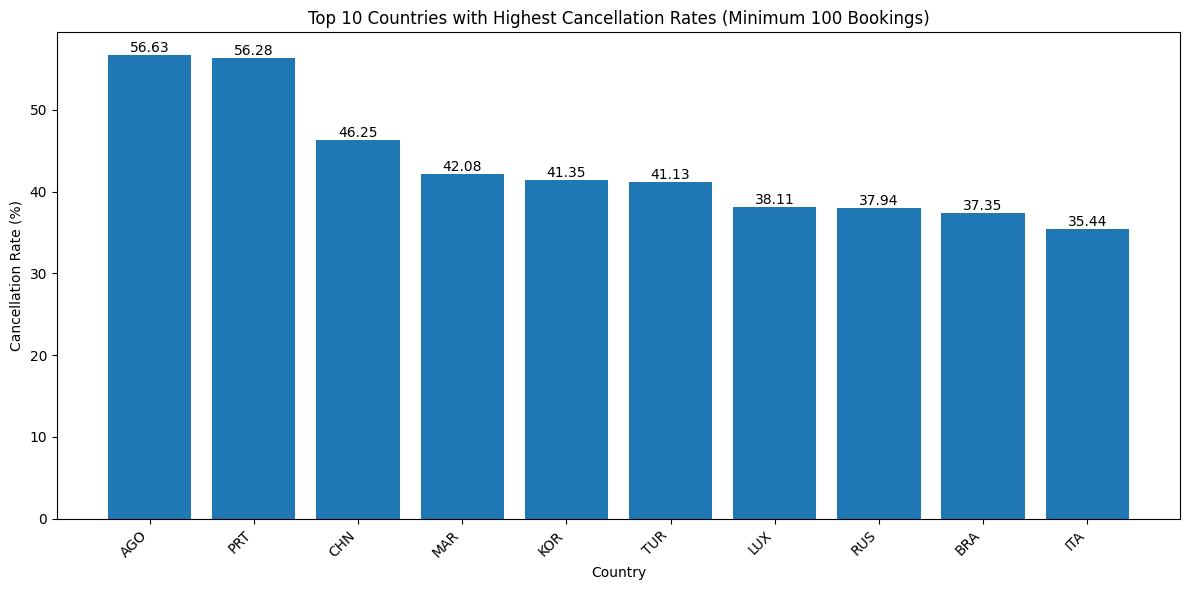

In [ ]:
# คำนวณอัตราการยกเลิกการจองของแต่ละประเทศ
cancellation_rates_by_country = df.groupby('country').agg(
    total_bookings=('reservation_count', 'sum'),
    total_cancellations=('is_canceled', 'sum')
).reset_index()

# กรองประเทศที่มีการจองมากกว่าเท่ากับ 100
cancellation_rates_by_country = cancellation_rates_by_country[cancellation_rates_by_country['total_bookings'] >= 100]

# คำนวณอัตราการยกเลิก
cancellation_rates_by_country['cancellation_rate'] = (
    cancellation_rates_by_country['total_cancellations'] /
    cancellation_rates_by_country['total_bookings']
) * 100

# เรียงลำดับตามอัตราการยกเลิกจากมากไปน้อยและเลือก 10 อันดับแรก
top_10_cancellation_rates = cancellation_rates_by_country.sort_values(
    'cancellation_rate', ascending=False
).head(10)

# แปลงรหัสประเทศเป็นชื่อประเทศเต็ม
def get_country_name(country_code):
  try:
    return pycountry.countries.get(alpha_2=country_code).name
  except:
    return country_code

top_10_cancellation_rates['country_name'] = top_10_cancellation_rates['country'].apply(get_country_name)


# สร้าง bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(top_10_cancellation_rates['country_name'], top_10_cancellation_rates['cancellation_rate'])
plt.xlabel('Country')
plt.ylabel('Cancellation Rate (%)')
plt.title('Top 10 Countries with Highest Cancellation Rates (Minimum 100 Bookings)')
plt.xticks(rotation=45, ha='right')

# เพิ่ม data label บนแท่ง
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()



<ipython-input-44-93ef766e071e>:53: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




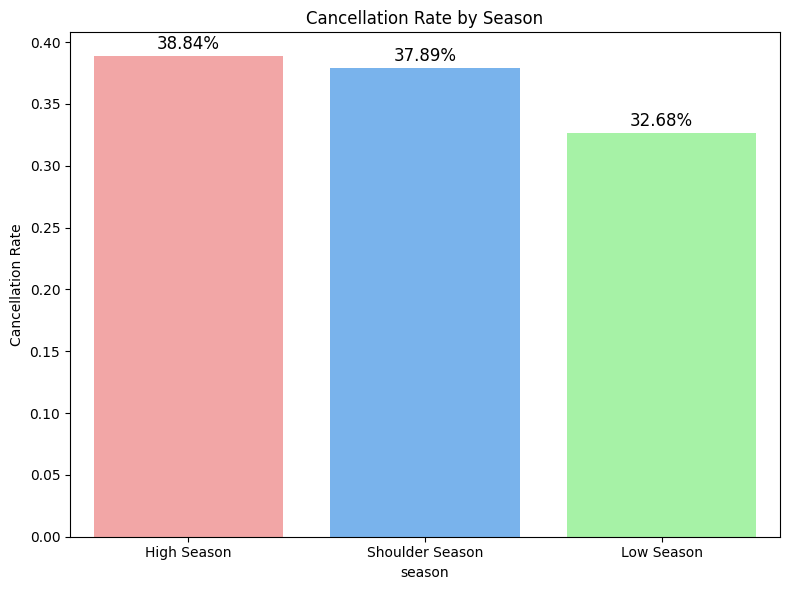

In [ ]:
#เพิ่ม Season
month_mapping = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

# Use the map function to replace month numbers with month names
df['arrival_date_month'] = df['arrival_date_month'].map(month_mapping)

def categorize_season(month):
    if month in ['June', 'July', 'August', 'September']:
        return 'High Season'
    elif month in ['November', 'December', 'January', 'February']:
        return 'Low Season'
    else:
        return 'Shoulder Season'

# Apply the categorization
df['season'] = df['arrival_date_month'].apply(categorize_season)

# Re-run the season analysis
season_data = df.groupby('season').agg({
    'is_canceled': ['mean', 'count'],
    'lead_time': 'mean',
    'is_special_requests': 'mean',
    'adults': 'mean',
    'is_car_parking': 'mean'
}).reset_index()

#Flatten the column names for better readability
season_data.columns = ['season', 'cancellation_rate', 'total_bookings', 'avg_lead_time',
                       'avg_special_requests', 'avg_adults', 'avg_car_parking_spaces']

# Reorder the season_data DataFrame based on the desired order
season_order = ['High Season', 'Shoulder Season', 'Low Season']
season_data = season_data.set_index('season').loc[season_order].reset_index()

# Custom color palette for the first chart
custom_palette = ['#ff9999', '#66b3ff', '#99ff99']

# Plot 1: Cancellation rate by season (with custom color)
plt.figure(figsize=(8, 6))
ax1 = sns.barplot(x='season', y='cancellation_rate', data=season_data, palette=custom_palette)
ax1.set_title('Cancellation Rate by Season')
ax1.set_ylabel('Cancellation Rate')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()


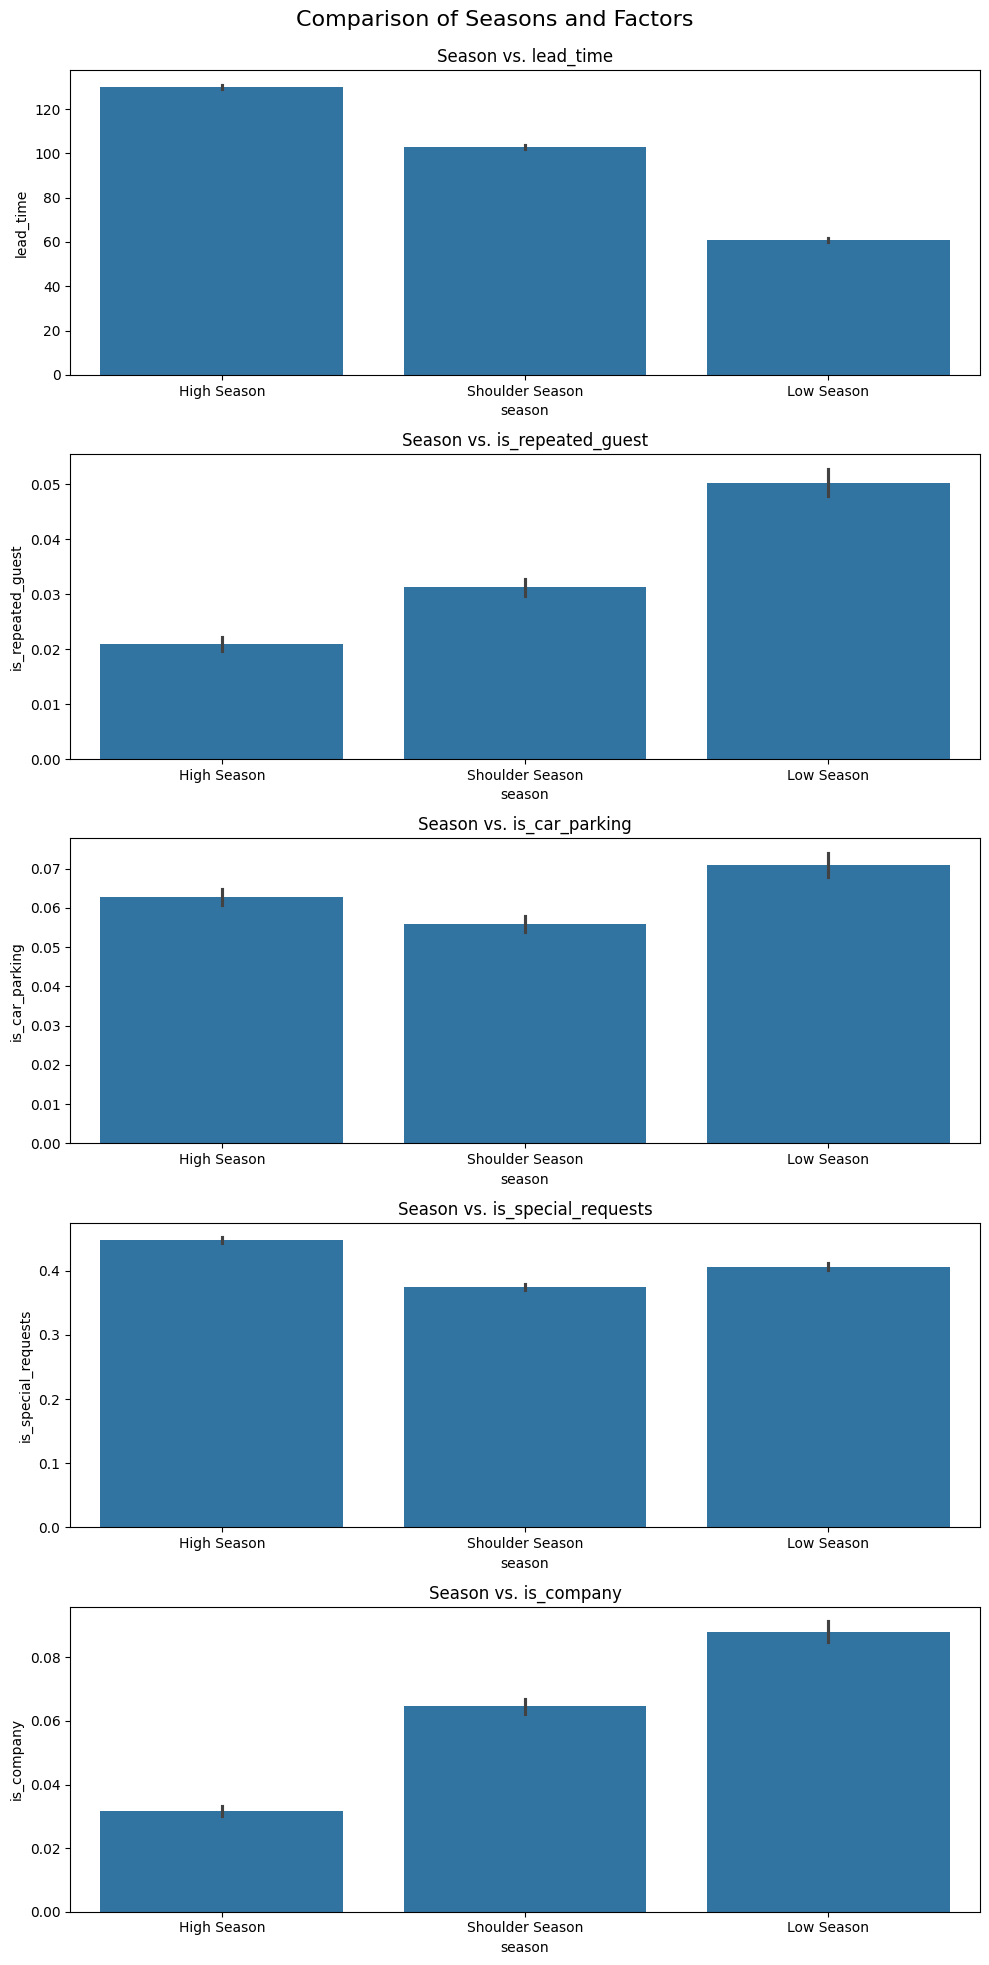

In [ ]:
factors_to_analyze = ['lead_time', 'is_repeated_guest', 'is_car_parking', 'is_special_requests', 'is_company']

# Create subplots for each factor
fig, axes = plt.subplots(nrows=len(factors_to_analyze), ncols=1, figsize=(10, 20))
fig.suptitle('Comparison of Seasons and Factors', fontsize=16)

for i, factor in enumerate(factors_to_analyze):
    ax = axes[i]
    sns.barplot(x='season', y=factor, data=df, ax=ax)
    ax.set_title(f'Season vs. {factor}')
    ax.set_ylabel(factor)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


In [ ]:
factors_to_analyze = ['lead_time', 'is_repeated_guest', 'is_car_parking', 'is_special_requests', 'is_company']

# Create subplots for each factor
fig, axes = plt.subplots(nrows=len(factors_to_analyze), ncols=1, figsize=(10, 20))
fig.suptitle('Comparison of Seasons and Factors', fontsize=16)

for i, factor in enumerate(factors_to_analyze):
    ax = axes[i]
    if factor == 'lead_time':
      sns.boxplot(x='season', y=factor, data=df, ax=ax)
    else:
      sns.barplot(x='season', y=factor, data=df, ax=ax)
    ax.set_title(f'Season vs. {factor}')
    ax.set_ylabel(factor)

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


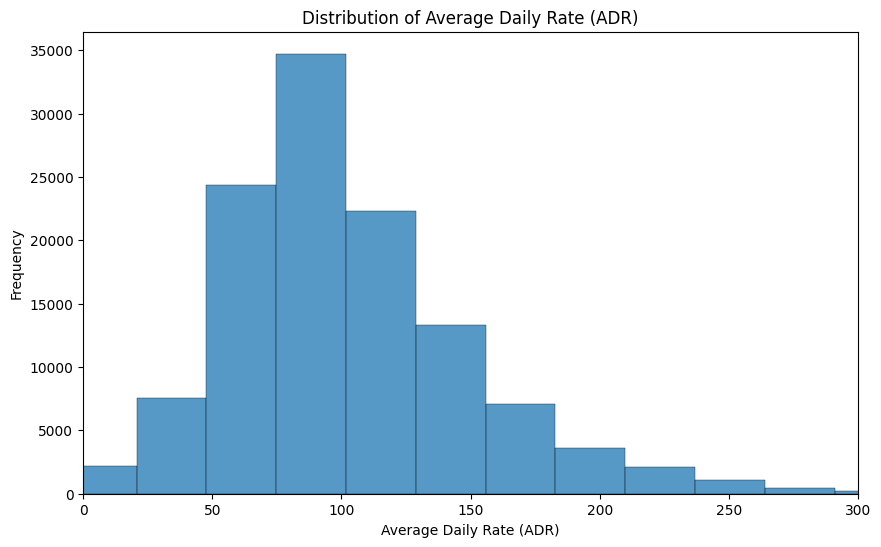

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['adr'], bins=200)
plt.xlim(0, 300)  # Set x-axis limits to 0-300
plt.xlabel('Average Daily Rate (ADR)')
plt.ylabel('Frequency')
plt.title('Distribution of Average Daily Rate (ADR)')
plt.show()


In [ ]:
df['adr'].skew()

10.619948360505159

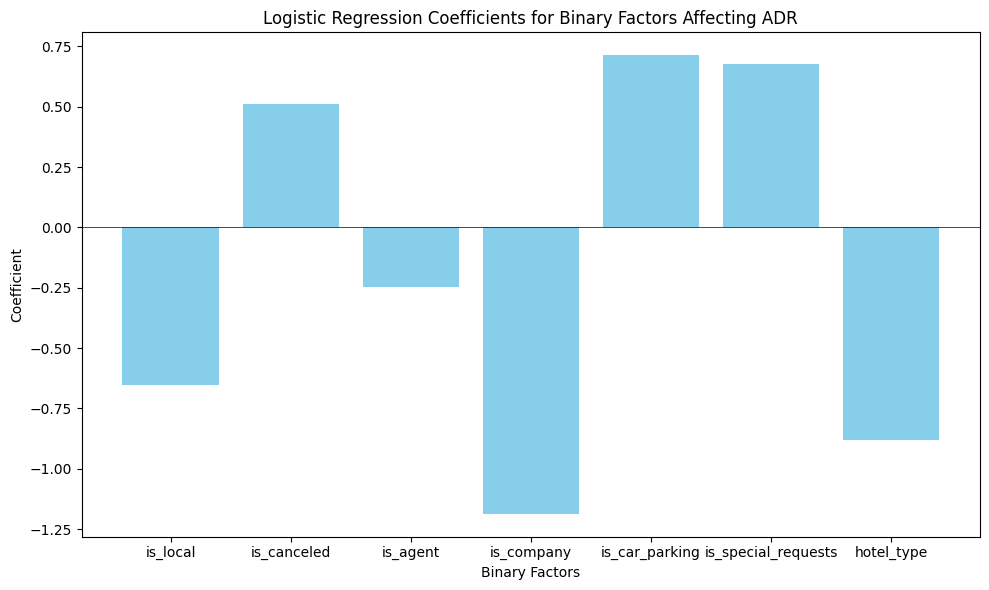

In [ ]:
# Prepare binary ADR (classify into high or low, using median ADR as the threshold)
median_adr = df['adr'].median()
df['adr_binary'] = (df['adr'] > median_adr).astype(int)

# Select binary categorical factors
binary_factors = ['is_local', 'is_canceled', 'is_agent', 'is_company', 'is_car_parking', 'is_special_requests', 'hotel_type']

# Prepare the data for logistic regression
X = df[binary_factors]
y = df['adr_binary']

# Fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X, y)

# Get the coefficients for each binary factor
coefficients = pd.DataFrame({
    'Factor': binary_factors,
    'Coefficient': log_reg.coef_[0]
})

plt.figure(figsize=(10, 6))
plt.bar(coefficients['Factor'], coefficients['Coefficient'], color='skyblue')

# Add title and labels
plt.title('Logistic Regression Coefficients for Binary Factors Affecting ADR')
plt.axhline(0, color='black',linewidth=0.5)
plt.xlabel('Binary Factors')
plt.ylabel('Coefficient')

# Display the plot
plt.tight_layout()
plt.show()

<ipython-input-59-fbd289b12809>:17: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



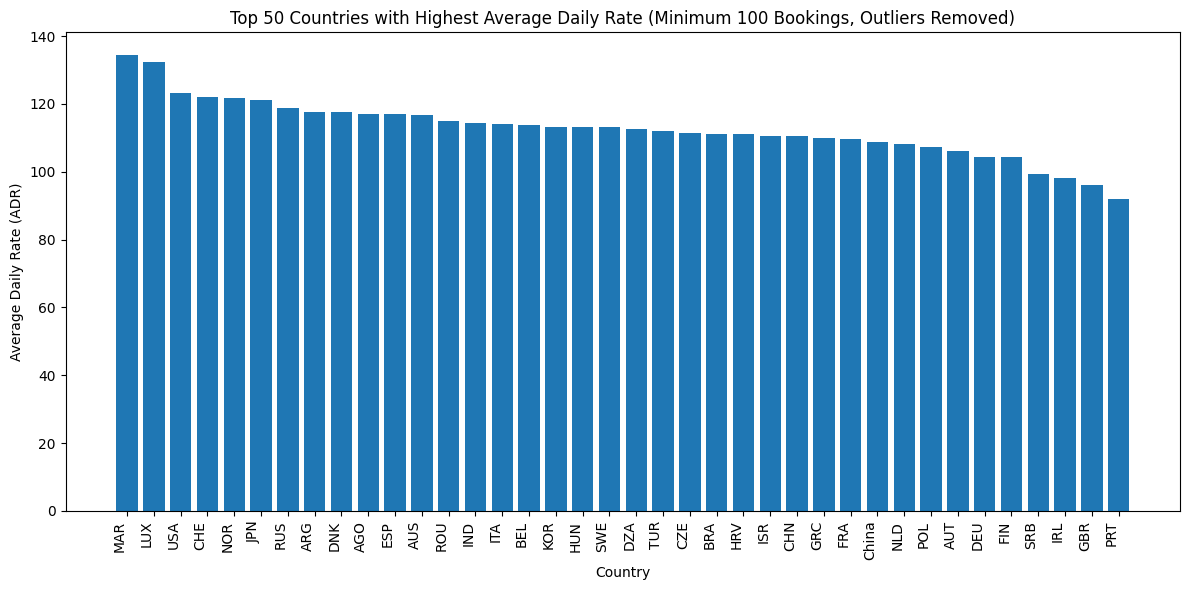

In [ ]:

# Calculate the average ADR for each country, considering only bookings with at least 100 reservations.
adr_by_country = df.groupby('country').agg(
    avg_adr=('adr', 'mean'),
    total_bookings=('reservation_count', 'sum')
).reset_index()
adr_by_country = adr_by_country[adr_by_country['total_bookings'] >= 100]

# Remove outliers based on ADR percentile (2.5 to 97.5).
def remove_outliers_by_country(group):
    lower_bound = group['avg_adr'].quantile(0.025)
    upper_bound = group['avg_adr'].quantile(0.975)
    return group[(group['avg_adr'] >= lower_bound) & (group['avg_adr'] <= upper_bound)]

adr_by_country_filtered = adr_by_country.groupby('country').apply(remove_outliers_by_country).reset_index(drop=True)

# Sort the countries by average ADR in descending order and select the top 50.
top_50_adr_countries = adr_by_country_filtered.sort_values(
    'avg_adr', ascending=False
).head(50)

# Convert country code to country name for better readability
top_50_adr_countries['country_name'] = top_50_adr_countries['country'].apply(get_country_name)

# Create a bar chart of the top 50 countries with the highest average ADR.
plt.figure(figsize=(12, 6))
plt.bar(top_50_adr_countries['country_name'], top_50_adr_countries['avg_adr'])

plt.xlabel('Country')
plt.ylabel('Average Daily Rate (ADR)')
plt.title('Top 50 Countries with Highest Average Daily Rate (Minimum 100 Bookings, Outliers Removed)')
plt.xticks(rotation=90, ha='right')

plt.tight_layout()
plt.show()


In [ ]:

# Calculate the average ADR for each country, considering only bookings with at least 100 reservations.
adr_by_country = df.groupby('country').agg(
    avg_adr=('adr', 'mean'),
    total_bookings=('reservation_count', 'sum')
).reset_index()
adr_by_country = adr_by_country[adr_by_country['total_bookings'] >= 100]

# Plot heatmap อัตราการยกเลิกตามแผนที่โลก
fig = px.choropleth(adr_by_country, locations="country", locationmode='ISO-3',
                    color="avg_adr", hover_name="country",
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.update_layout(title_text='Average ADR by Country, (minimum 100 bookings)')
fig.show()


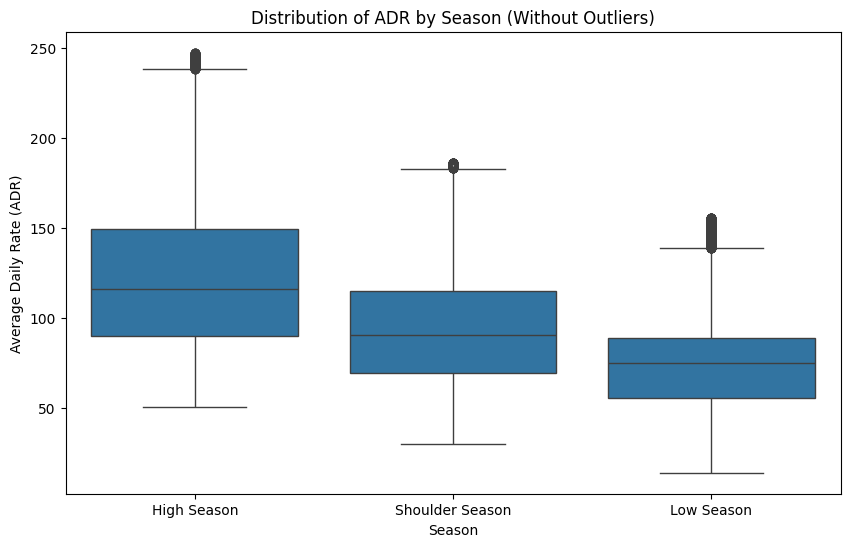

In [ ]:

# Calculate the IQR for ADR within each season
lower_bound_by_season = df.groupby('season')['adr'].quantile(0.025)
upper_bound_by_season = df.groupby('season')['adr'].quantile(0.975)

# Create a list to store the data for the boxplot
boxplot_data = []
for season in df['season'].unique():
  season_df = df[df['season'] == season]
  season_df_no_outliers = season_df[(season_df['adr'] >= lower_bound_by_season[season]) & (season_df['adr'] <= upper_bound_by_season[season])]
  boxplot_data.extend([(season, adr) for adr in season_df_no_outliers['adr']])

# Create a new DataFrame for boxplot data
boxplot_df = pd.DataFrame(boxplot_data, columns=['season', 'adr'])

# Create the boxplot, sorted by median ADR
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='adr', data=boxplot_df, order=boxplot_df.groupby('season')['adr'].median().sort_values(ascending=False).index)
plt.xlabel('Season')
plt.ylabel('Average Daily Rate (ADR)')
plt.title('Distribution of ADR by Season (Without Outliers)')
plt.show()
